In [2]:
import requests
from bs4 import BeautifulSoup
import pdb
import re
import json
import time

In [2]:
import requests

# Reverse-engineered by looking at the request done in Chrome Network tab
# **Headers > Form Data** is the interesting part (POST data submitted by the form)
# Right-click > export to cURL then copy to https://curl.trillworks.com/
# to get the Python requests syntax

def get_ship_html(ship_id):
    headers = {
        'Connection': 'keep-alive',
        'Cache-Control': 'max-age=0',
        'Origin': 'https://www.memoiredeshommes.sga.defense.gouv.fr',
        'Upgrade-Insecure-Requests': '1',
        'Content-Type': 'application/x-www-form-urlencoded',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36',
        'Sec-Fetch-User': '?1',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-Mode': 'navigate',
        'Referer': 'https://www.memoiredeshommes.sga.defense.gouv.fr/fr/arkotheque/client/mdh/compagnie_des_indes/armement_navires.php?action=1&todo=modif_recherche',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7',
    }

    data = {
      'action': '1',
      'todo': 'rechercher',
      'r_sel_navire': ship_id,
      'form_rech_date_debut': '1600',
      'form_rech_date_fin': '1800',
      'r_sel_nom_capitaine': '',
      'r_sel_lieu_depart_bat': '',
      'r_sel_lieu_destination_bat': '',
      'r_sel_typearmateur': '',
      'r_sel_proprietaire': ''
    }

    return requests.post('https://www.memoiredeshommes.sga.defense.gouv.fr/fr/arkotheque/client/mdh/compagnie_des_indes/armement_navires.php', headers=headers, data=data).content

In [3]:
# Parse ship IDs from the selector HTML on the search page
def parse_all_ship_ids():
    headers = {
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36',
        'Sec-Fetch-User': '?1',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Sec-Fetch-Site': 'none',
        'Sec-Fetch-Mode': 'navigate',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7',
    }

    search_page = requests.get('https://www.memoiredeshommes.sga.defense.gouv.fr/fr/arkotheque/client/mdh/compagnie_des_indes/armement_navires.php', headers=headers).content

    t = BeautifulSoup(search_page, 'html.parser')
    ship_options = t.find(id="r_sel_navire").find_all("option")
    ship_ids = {opt.attrs.get('value') for opt in ship_options}
    return sorted([x for x in ship_ids if x is not None and x != ''])

In [32]:
def parse_ship_journeys(ship_html):
    t = BeautifulSoup(ship_html, 'html.parser')
    journeys_data = []
    journeys = t.find_all('fieldset', class_='detail_navire')
    for j in journeys:
        header = j.find(class_='retrait_navire')
        dates_elem = header.find('small')
        if dates_elem is not None:
            dates = header.find('small').text.split('-')
            start_date, end_date = dates[0], dates[1] if len(dates) > 1 else dates[0]
        else:
            start_date, end_date = None, None
        itinerary = header.find('h3')
        stops = itinerary.contents[0].split(' → ') if itinerary is not None else []
        ship_name_elem = j.find('h2')
        ship_name = ship_name_elem.contents[0].split('\t')[0] if ship_name_elem is not None else None

        table_data = []
        table = j.find("div", id=re.compile("^detail_campagne_"))
        if table is not None:
            table_rows = table.find_all("tr")
            for row in table_rows[1:]:  # `1:` because we skip header
                entries = row.find_all("td")
                table_data.append({
                    'location': entries[0].text, 
                    'status': entries[1].text, 
                    'date': entries[2].text
                })

        journey_data = {
            'start_date': start_date,
            'end_date': end_date,
            'stops': stops,
            'ship_name': ship_name,
            'ship_log': table_data
        }
        journeys_data.append(journey_data)
    return journeys_data

In [5]:
list(parse_all_ship_ids())[:10]

['Q+ly6HM=',
 'Q291cmV1cg==',
 'Q291cnJpZXIgZGUgQm91cmJvbg==',
 'Q291cnJpZXIgZGUgbJLubGUgZGUgRnJhbmNl',
 'Q291cnJpZXIgZJJPcmzpYW5z',
 'Q29sb21iZQ==',
 'Q29sb24=',
 'Q29sb25pZQ==',
 'Q29tbWVyY2U=',
 'Q29tcGFnbmllIGRlcyBJbmRlcw==']

In [28]:
# Initialization
ship_ids = parse_all_ship_ids()
ships_data = {}

In [37]:
# Expensive compute
for i, ship_id in enumerate(ship_ids, 1):
    if ship_id in ships_data:
        print(f"Skipping {ship_id} since we already have the data")
        continue
    print(f"Fetching data for {ship_id} ({i}/{len(ship_ids)})...")

    ship_html = get_ship_html(ship_id)
    ship_journeys = parse_ship_journeys(ship_html)
    if ship_journeys:
        ships_data[ship_id] = ship_journeys
    else:
        print("No data found! Did we get throttled?")
    time.sleep(30)  # to avoid getting throttled by the website


Skipping Q+ly6HM= since we already have the data
Skipping Q291cmV1cg== since we already have the data
Skipping Q291cnJpZXIgZGUgQm91cmJvbg== since we already have the data
Skipping Q291cnJpZXIgZGUgbJLubGUgZGUgRnJhbmNl since we already have the data
Skipping Q291cnJpZXIgZJJPcmzpYW5z since we already have the data
Skipping Q29sb21iZQ== since we already have the data
Skipping Q29sb24= since we already have the data
Skipping Q29sb25pZQ== since we already have the data
Skipping Q29tbWVyY2U= since we already have the data
Skipping Q29tcGFnbmllIGRlcyBJbmRlcw== since we already have the data
Skipping Q29tdGUgZGUgSnVtaWxsYWM= since we already have the data
Skipping Q29tdGUgZGUgTGFuZ2Vyb24= since we already have the data
Skipping Q29tdGUgZGUgTWF1cmVwYXM= since we already have the data
Skipping Q29tdGUgZGUgTmFyYm9ubmU= since we already have the data
Skipping Q29tdGUgZGUgTmVueQ== since we already have the data
Skipping Q29tdGUgZGUgU2FpbnQtR2VybWFpbg== since we already have the data
Skipping Q29tdGU

No data found! Did we get throttled?
Skipping RGlhbmU= since we already have the data
Skipping RGlnb3ZpbGxl since we already have the data
Skipping RGlndWU= since we already have the data
Skipping RGlsaWdlbnQ= since we already have the data
Skipping RGlsaWdlbnQgUG9zdGlsbG9u since we already have the data
Skipping RGlsaWdlbnRl since we already have the data
Skipping RHJ5YWRl since we already have the data
Skipping RHJhZ29u since we already have the data
Skipping RHJhZ29uIFZvbGFudA== since we already have the data
Skipping RHJvbWFkYWlyZQ== since we already have the data
Skipping RHVjIGR1IE1haW5l since we already have the data
Skipping RHVjIGRlIE5vYWlsbGVz since we already have the data
Skipping RHVjIGRlIE5vcm1hbmRpZQ== since we already have the data
Skipping RHVjIGRlIEJlYXVmb3J0 since we already have the data
Skipping RHVjIGRlIEJlZGZvcnQ= since we already have the data
Skipping RHVjIGRlIEJlcnJ5 since we already have the data
Skipping RHVjIGRlIEJvdXJib24= since we already have the data
Sk

Fetching data for Vmljb210ZSBkZSBWZWF1eA== (721/752)...
Fetching data for VmljdG9pcmU= (722/752)...
Fetching data for VmljdG9y (723/752)...
Fetching data for VmljdG9yaWV1c2U= (724/752)...
Fetching data for VmllcmdlIGRlIEdy4mNl (725/752)...
Fetching data for VmlnaWxhbnQ= (726/752)...
Fetching data for VmlnaWxhbnRl (727/752)...
Fetching data for VmlsbGUgZGUgTG9yaWVudA== (728/752)...
Fetching data for VmlsbGUgZGUgU3RhZGU= (729/752)...
Fetching data for VmlsbGUgZJJBcmNoYW5nZWw= (730/752)...
Fetching data for VmlsbGUgZJJIb25mbGV1cg== (731/752)...
Fetching data for VmlsbGV2YXVsdA== (732/752)...
Fetching data for VmlsbGVmbGl4 (733/752)...
Fetching data for VuludXM= (734/752)...
Fetching data for Wm9kaWFxdWU= (735/752)...
Fetching data for Wuls6Q== (736/752)...
Fetching data for WulwaHly (737/752)...
Fetching data for Y2Fub3QgZGVzIGZlcm1lcyBkZSBMb2NtYWxv (738/752)...
Fetching data for Y2Fub3QgZGVzIGZlcm1lcyBkZSBMb3JpZW50 (739/752)...
Fetching data for Y2Fub3QgZGVzIGZlcm1lcyBkZSBQb3J0LUxvdWlz (

In [3]:
# with open('ship_data.json', 'w', encoding='utf8') as f:
#     json.dump(ships_data, f, ensure_ascii=False)

/Users/daniel/repos/imperial-networks


In [3]:
with open('scripts/ship_data.json', encoding='utf8') as f:
    ships_data = json.load(f)

In [6]:
from collections import Counter
ship_log_entries = Counter()
stops = Counter()
for k, v in ships_data.items():
    for entry in v:
        for stop in entry['stops']:
            stops[stop] += 1
        for e in entry['ship_log']:
            ship_log_entries[e['location']] += 1
            

In [7]:
ship_log_entries.most_common(10)

[('Lorient', 3188),
 ('île de France', 1219),
 ('île Bourbon', 647),
 ('Pondichéry', 600),
 ('Sénégal', 340),
 ('Gorée', 285),
 ('Ascension', 194),
 ('Cap-Français', 165),
 ('cap de Bonne-Espérance', 131),
 ('Cadix', 121)]

In [49]:
stops.most_common(100)

[('Lorient', 2505),
 ('Mascareignes', 225),
 ('Inde et Mascareignes', 224),
 ('Sénégal', 162),
 ('Saint-Domingue', 155),
 ('Louisiane', 117),
 ('Le Havre', 116),
 ('Cap de Bonne-Espérance', 114),
 ('Cadix', 107),
 ('Chine', 106),
 ('Sénégal et Gorée', 105),
 ('Ascension', 104),
 ('Port-Louis', 101),
 ('Inde', 93),
 ('Nantes', 92),
 ('?', 89),
 ('Bordeaux', 82),
 ('Saint-Malo', 80),
 ('Martinique', 71),
 ('Brest', 66),
 ('Gorée', 65),
 ('La Rochelle', 62),
 ('Antilles', 60),
 ('Marseille', 59),
 ('île de France', 49),
 ('Rochefort', 46),
 ('Brésil', 44),
 ('vaisseau de côte', 44),
 ('île de France ?', 40),
 ('Pondichéry', 38),
 ('service des fermes', 37),
 ('Anjouan', 36),
 ('Cap-Vert', 32),
 ('Ténériffe', 30),
 ('cabotage', 30),
 ('Sainte-Hélène', 27),
 ('Île de France', 27),
 ('Juda et côtes de Guinée', 25),
 ('Sète', 25),
 ('Sainte-Hélène et Ascension', 24),
 ('Madagascar et Mascareignes', 23),
 ('Lisbonne', 23),
 ('Cap-Français', 22),
 ('Mascareignes et Madagascar', 21),
 ('Bordeaux

In [8]:
LOCATIONS = {
    'Isle Bourbon & Isle of France': ['Mascareignes', 'îles de France et de Bourbon', 'île Bourbon', 'Port-Louis, île de France', 'île de France', 'Île de France'] ,
    'Senegal': ['Sénégal', 'Sénégal et Gorée', 'Gorée', 'Cap-Vert', 'Juda et côtes de Guinée', 'Juda'],
    'Caribbean': ['Saint-Domingue', 'Martinique', 'Antilles', 'Cap-Français', 'Saint-Louis, St-Domingue', 'Léogane', 'Port-au-Prince', 'La Grenade (île de)', 'Petit-Goâve, St-Domingue', 'Guadeloupe'],
    'Louisiana': ['Louisiane', 'Ascension', 'Nouvelle-Orléans', 'Biloxy, Louisiane'],
    'France': ['Le Havre', 'Nantes', 'Bordeaux', 'Saint-Malo', 'Brest', 'La Rochelle', 'Marseille', 'Rochefort', 'Sète', 'Bayonne', 'Honfleur', 'Dunkerque', 'Rouen', 'Groix', 'Lorient', 'Toulon', 'Paimboeuf', 'Belle-île-en-Mer'],
    'Madagascar': ['Madagascar', 'Port-Louis', 'Anjouan', 'Fort-Dauphin, Madagascar', 'Sainte-Marie, Madagascar', 'baie de St-Augustin, Madagsascar'],  # TODO
    'India': ['Inde', 'Karaikal', 'Karikal', 'Pondichéry', 'Bengale', 'Calicut', 'Goa', 'Chandernagor', 'Négapatam', 'Madras', 'sur le Gange'],
    'New France': ['Louisbourg (île Royale), Canada', 'Saint-Pierre et Miquelon', 'Terre-Neuve'],
    'Guyana': ['Guyane', 'Cayenne'],
}



LINKS = []

def normalize_location(location):
    matches = []
    # in cases like "Mascareignes et Madagascar", we want to
    # retain both 'Mascareignes' (Bourbon) and 'Madagascar' as separate stops
    # That's why we return a list as opposed to a single name.
    for key, synonyms in LOCATIONS.items():
        for synonym in synonyms:
            if synonym in location:
                matches.append((key, synonym))
                break
    # If >1 stop, return stops in their order of appearance in the input
    # eg "Inde et Mascareignes" => ['India', 'Bourbon']
    # but "Mascareignes et Madagascar" => ['Bourbon', 'Madagascar']
    res = [m[0] for m in sorted(matches, key=lambda m: location.index(m[1]))]
    return res

def normalize_itinerary(itinerary):
    # normalize locations, skip unknown locations, no contiguous duplicates
    result = []
    for stop in itinerary:
        next_stops = normalize_location(stop)
        if len(result) == 0 or len(result) > 0 and all(s != result[-1] for s in next_stops):
            result += next_stops
    return result if len(result) > 1 else []

def make_preview_str(entry):
    # In some cases the ship_log has more accurate data that can contradict this itinerary
    # for example with COURRIER DE BOURBON 
    return f"{entry['ship_name']} ({entry['start_date']}-{entry['end_date']}): " + ' → '.join(entry['stops'])

def ship_entry_to_links(entry, stops):
    links = []
    for i in range(1, len(stops)):
        links.append({
            'from': stops[i-1],
            'to': stops[i],
            # we only have the start/end years for the full journey
            # not the intermediary stops, so we use the end_date for
            # all stops after departure
            'from_date': entry['start_date'] if i == 1 else entry['end_date'],
            'to_date': entry['end_date'],
            'preview': make_preview_str(entry)
        })
    return links

for k, v in ships_data.items():
    for entry in v:
        
        stops_v1 = normalize_itinerary(entry['stops'])
        stops_v2 = normalize_itinerary([e['location'] for e in entry['ship_log']])

        # use the itinerary with the most detail out of the two
        stops = stops_v1 if len(stops_v1) > len(stops_v2) else stops_v2
        LINKS += ship_entry_to_links(entry, stops)
        
        
# UNKNOWN_STOPS_COUNTER.most_common(100)

In [6]:
def print_obj(obj):
    print(json.dumps(obj, ensure_ascii=False, indent=2))

# print_obj(LINKS[:5])

In [36]:
with open ('links.json', 'w', encoding='utf-8') as f:
    json.dump(LINKS, f, ensure_ascii=False)

!cat links.json | json-to-js > data/ships/links.js
!echo "const SHIPS_LINKS = $(cat data/ships/links.js);" > data/ships/links.js
!rm links.json

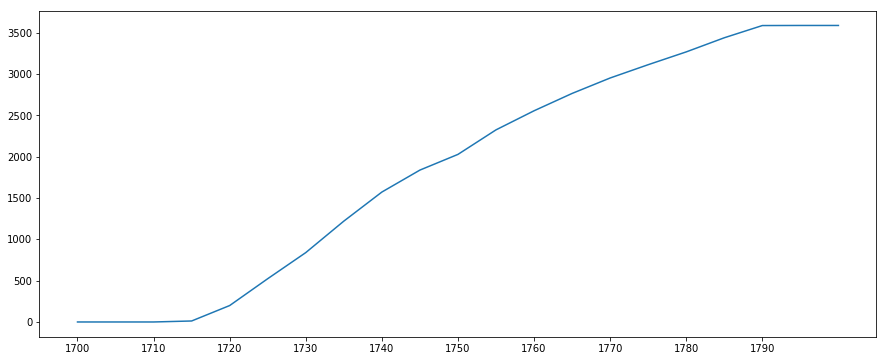

In [33]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]
from collections import defaultdict, Counter

# cumulative ship departures over time
x = list(np.arange(1700, 1801, 5))
y = [0 for _ in x]
for link in LINKS:
    for i in range(len(x)):
        if int(link['from_date']) <= x[i]:
            y[i] += 1

plt.xticks(np.arange(1700, 1800, 10))

plt.plot(x, y)

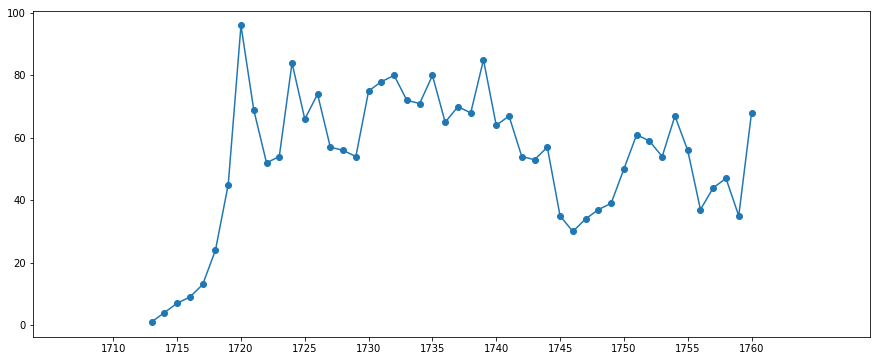

In [43]:
# non-cumulative
by_year = Counter()
for link in LINKS:
    year = int(link['from_date'])
    if year <= 1760:
        by_year[year] += 1
x, y = [], []
for a, b in sorted(by_year.items(), key= lambda item: item[0]):
    x.append(a) ; y.append(b)

plt.xticks(np.arange(1710, 1761, 5))
plt.scatter(x, y)
plt.plot(x, y)

In [7]:
for k, v in ships_data.items():
    for entry in v:
        for stop in entry['stops']:
            if 'Guyane' in stop:
                print_obj(entry)
        for e in entry['ship_log']:
            if 'Guyane' in stop:
                print_obj(entry)

{
  "start_date": "1724",
  "end_date": "1726",
  "stops": [
    "Le Havre",
    "Lorient",
    "Juda",
    "Guyane",
    "Lorient"
  ],
  "ship_name": "EXPÉDITION",
  "ship_log": [
    {
      "location": "Le Havre",
      "status": "armement",
      "date": "06/08/1724"
    },
    {
      "location": "Le Havre",
      "status": "départ",
      "date": "08/08/1724"
    },
    {
      "location": "Groix",
      "status": "arrivée",
      "date": "17/08/1724"
    },
    {
      "location": "Port-Louis",
      "status": "arrivée",
      "date": "18/08/1724"
    },
    {
      "location": "Lorient",
      "status": "départ",
      "date": "04/09/1724"
    },
    {
      "location": "Gorée",
      "status": "arrivée",
      "date": "04/10/1724"
    },
    {
      "location": "Gorée",
      "status": "départ",
      "date": "17/10/1724"
    },
    {
      "location": "Mesurade",
      "status": "arrivée",
      "date": "09/12/1724"
    },
    {
      "location": "Mesurade",
      "status": 

In [0]:
ships_data